In [63]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns       
import pandas as pd                           # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats
from iminuit.cost import LeastSquares
from scipy import optimize
from scipy.stats import kstest
from scipy.stats import poisson

In [2]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

plt.rcParams['font.size'] = 18     # Set some basic plotting parameters

# Problem 1.3

In [192]:
lamb = 241089/24
r =  np.arange(0,1000)

np.sqrt(lamb)

(lamb-9487)/np.sqrt(lamb)

5.571124816057189

# Problem 1.4

In [3]:
def binom(p,r,n):
	return p**r*(1-p)**(n-r)*np.math.factorial(n)/(np.math.factorial(r)*np.math.factorial((n-r)))

In [4]:
prob = []

for i in range(1,21):
	prob.append(binom(0.03,i,20))

prob = np.array(prob)
print(f'You have a {(1-np.sum(prob))*100} probability of not hitting the taget within the first 20 shots')

You have a 54.37943429267476 probability of not hitting the taget within the first 20 shots


In [5]:
n = 4000
p = 0.03

mu = n*p
sigma = np.sqrt(n*p*(1-p))

def gauss(x,mu,sigma):
	return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))

count = 0
gauss_prob = []
for i in range(0,100):
	count += 1
	gauss_prob.append(gauss(i,mu,sigma))

gauss_prob = np.array(gauss_prob)

print(f'{count} calls to the function')
print(f'The probability to hit the target 100 times given 4000 shots is {np.sum(gauss_prob)*100}, with mu = {mu} and sigma = {sigma}')

100 calls to the function
The probability to hit the target 100 times given 4000 shots is 2.866512302038035, with mu = 120.0 and sigma = 10.788883167408942


# Problem 2.2

In [6]:
drug = np.array([3.7,-1.2,-0.2,0.7,0.8])
placebo = np.array([1.5, -1.0, -0.7, 0.5, 0.1])
print(f'The mean is {np.mean(drug)}, the standard deviation is {np.std(drug)} and the uncertainty on the mean is {np.std(drug)/np.sqrt(5)}')

The mean is 0.76, the standard deviation is 1.6378034070058594 and the uncertainty on the mean is 0.7324479503691713


In [7]:
print(np.sqrt(np.sum((placebo-np.mean(placebo))**2)/5-1), np.sqrt(np.std(placebo)))

nan 0.9438444247082267


/var/folders/63/gwq1zc2x00j6dxvm9c1j0rbm0000gn/T/ipykernel_50838/1364239942.py:1: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(np.sum((placebo-np.mean(placebo))**2)/5-1), np.sqrt(np.std(placebo)))


In [8]:
print(np.mean(placebo), np.std(placebo), np.std(placebo)/np.sqrt(5))

0.08 0.8908422980528035 0.3983967871356394


To test whether the placebo group has slept longer than the drug group i will perform a students t test on the measurements

In [9]:
s = np.sqrt(((5-1)*(np.sqrt(np.std(drug)))**2 + (5-1) * (np.sqrt(np.std(placebo)))**2) / (5 + 5 - 2))

print(s)

t_test = (np.mean(drug)-np.mean(placebo))/(s*np.sqrt(1/5)+np.sqrt(1/5))

print(f'We have a test value of {t_test} which gives us a p value of {0.49787} which means that the result is not significant, ergo the drug group does not sleep longer than the placebo groupØ')


1.124421118855979
We have a test value of 0.7157367299750227 which gives us a p value of 0.49787 which means that the result is not significant, ergo the drug group does not sleep longer than the placebo groupØ


# Problem 3

In [10]:
r = np.random
r.seed(42)

save_plots = False   
N_points = 10000      # Number of random points to be produced!

xmin = 0.0
xmax = 1.0
N_bins = 100

# Define f(x) = 2x, for x in [0,1]
def fx_2x(x) :
    # Normalization is N_points * binwidth:
    k = (xmax - xmin) / N_bins
    N = N_points * k
    return N * 8.0125*x**3*np.sin(np.pi*x)

In [11]:
N_try = 0
ymin = 0.0      # Minimum value the function will take!
ymax = 3.0      # Maximum value the function will take!
x_accepted = np.zeros(N_points)

for i in range(N_points):
    
    while True:
        
        # Count the number of tries, to get efficiency/integral
        N_try += 1                    
        
        # Range that f(x) is defined/wanted in:
        x_test = r.uniform(xmin, xmax)  
        
        # Upper bound for function values:
        y_test = r.uniform(ymin, ymax)
        
        if (y_test < 8.0125*x_test**3*np.sin(np.pi*x_test)):
            break
            
    x_accepted[i] = x_test

In [12]:
# Efficiency
eff = N_points / N_try                        

# Error on efficiency (binomial!)
eff_error = np.sqrt(eff * (1-eff) / N_try) 

# Integral
integral =  eff * (xmax-xmin) * (ymax-ymin)

# Error on integral
eintegral = eff_error * (xmax-xmin) * (ymax-ymin)  

print(f"\nIntegral of f(x) = x, x in [0, 1] is: \t {integral:7.4f} +- {eintegral:6.4f}")
print(f"The efficiency of the Accept/Reject method used here is: \t {eff:.2%} +/- {eff_error:.2%}")
# We normalized the function ahead of time, so we should hope to get a result consistent with unity!


Integral of f(x) = x, x in [0, 1] is: 	  0.9943 +- 0.0081
The efficiency of the Accept/Reject method used here is: 	 33.14% +/- 0.27%


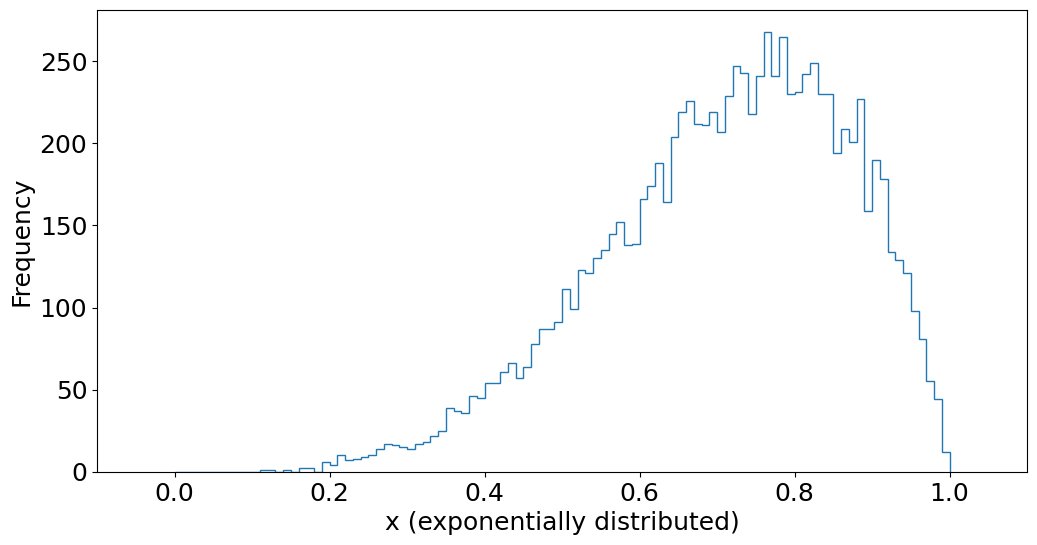

In [13]:
fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.hist(x_accepted, bins=N_bins, range=(xmin, xmax), histtype='step', label='histogram' )
ax2.set(xlabel="x (exponentially distributed)", ylabel="Frequency", xlim=(xmin-0.1, xmax+0.1));

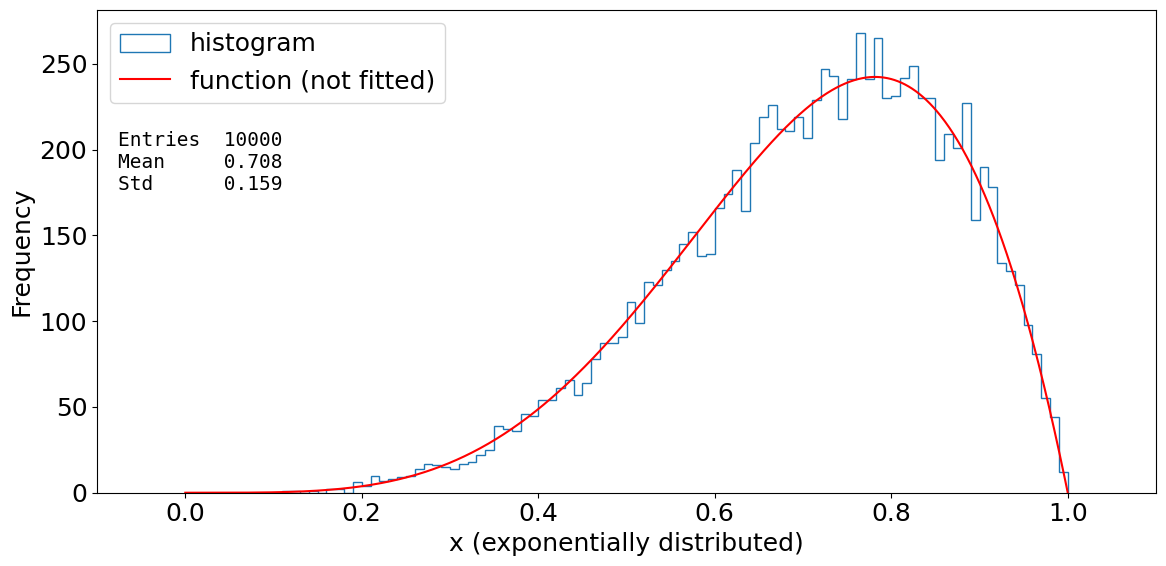

In [14]:
# Plot f(x)
x_axis2 = np.linspace(xmin, xmax, 1000)
y_axis2 = fx_2x(x_axis2)
ax2.plot(x_axis2, y_axis2, 'r-', label='function (not fitted)')

# Define the figure text
d2 = {'Entries': len(x_accepted),
      'Mean': x_accepted.mean(),
      'Std': x_accepted.std(ddof=1),
    }

# Add figure text
text2 = nice_string_output(d2, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.75, text2, ax2, fontsize=14)

# Add legend
ax2.legend(loc='best')
fig2.tight_layout()

# Save figure
if save_plots: 
    fig2.savefig("Hist_2x_AcceptRejectMethod.pdf", dpi=600)
    
# Show the figure
fig2

In [15]:
def f_fit(x,a):
    return N_points/N_bins*8.0125*x**a*np.sin(np.pi*x)

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(x_accepted, bins=N_bins, range=(xmin, xmax))
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)
x = x[y>0]
y = y[y>0]
sy = sy[sy>0]

chi2fit = Chi2Regression(f_fit, x, y, sy)
# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

minuit_chi2 = Minuit(chi2fit,a=1)
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
minuit_chi2.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 64.05                      │              Nfcn = 33               │
│ EDM = 4.66e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   3.021   │   0.022   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        a │
├───┼──────────┤
│ a │ 0.000487 │
└───┴──────────┘

In [16]:
def chi2_owncalc(x,a):
	y_fit = f_fit(x,a)
	chi2 = np.sum(((y - y_fit) / sy)**2)
	return chi2

#Calculate degrees of freedom
print(len(y[y>0])-1)

print(chi2_owncalc(x,3), stats.chi2.sf(chi2_owncalc(x,3), 85))

85
64.95516105014211 0.9480173429231933


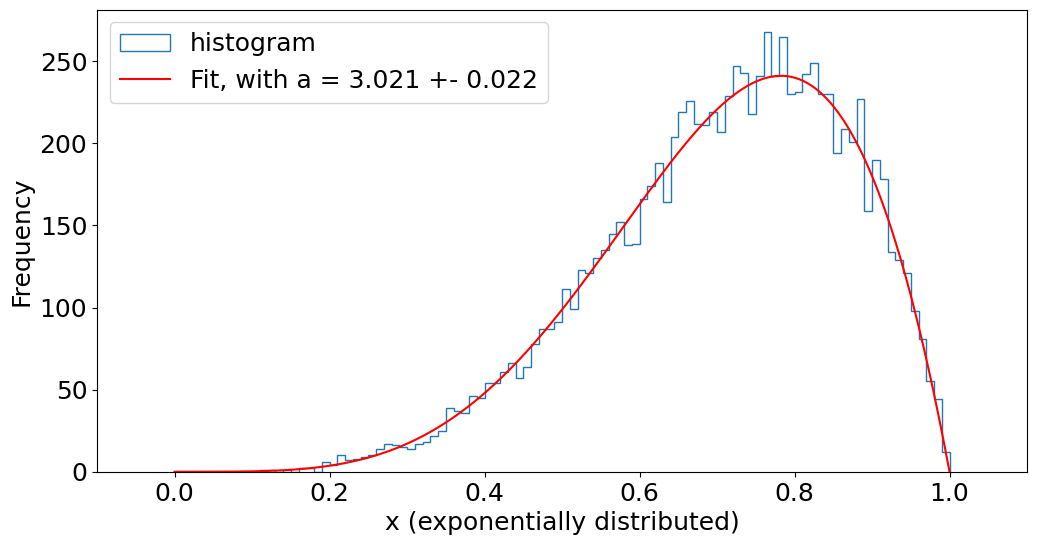

In [22]:
x_axis2 = np.linspace(xmin, xmax, 1000)
y_axis2 = f_fit(x_axis2,*minuit_chi2.values)


fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.hist(x_accepted, bins=N_bins, range=(xmin, xmax), histtype='step', label='histogram' )
ax2.plot(x_axis2, y_axis2, 'r-', label='Fit, with a = 3.021 +- 0.022')
ax2.set(xlabel="x (exponentially distributed)", ylabel="Frequency", xlim=(xmin-0.1, xmax+0.1));
ax2.legend()

In [32]:
(0.022/np.sqrt(10))*100

0.6957010852370433

# Problem 4.1

In [33]:
def read_grip(filename):
	dat = pd.read_csv(filename, sep = ',', header = 0, names = ["Dominant hand", "Dominant grip", "Non Dominant grip"]) 
	return dat

grip_strength = read_grip("data_GripStrength.txt")
Dom_hand = grip_strength["Dominant hand"]
Dom_grip = grip_strength["Dominant grip"]
Non_Dom_grip = grip_strength["Non Dominant grip"]

In [34]:
count = 0 
for i in Dom_hand:
	if i == 1:
		count +=1

print(f'The amount of people that are right handed are {np.round(count/len(Dom_hand), 2)}')
print(f'The mean of the Dominant grip is {np.mean(Dom_grip)} with a standard deviation of {np.std(Dom_grip)}, with an error on the mean of {np.std(Dom_grip)/np.sqrt(len(Dom_grip))}')
print(f'The mean of the non-Dominant grip is {np.mean(Non_Dom_grip)} with a standard deviation of {np.std(Non_Dom_grip)}, with an error on the mean of {np.std(Non_Dom_grip)/np.sqrt(len(Non_Dom_grip))}')



The amount of people that are right handed are 0.81
The mean of the Dominant grip is 444.93095238095236 with a standard deviation of 144.14294632510968, with an error on the mean of 15.727284819732663
The mean of the non-Dominant grip is 418.48178571428565 with a standard deviation of 137.3924578851255, with an error on the mean of 14.990746147014763


In [36]:
print(len(Dom_hand))

84


In [18]:
#To check whether the distributions are compatible we can see how many sigma away they are from another

(np.mean(Dom_grip)-np.mean(Non_Dom_grip))/np.std(Non_Dom_grip)

0.19250814108574277

In [37]:
#The mean and standard deviation of the individual differences in grip strength

print(f'The mean of the difference grip is {np.mean(Dom_grip-Non_Dom_grip)} with a standard deviation of {np.std(Dom_grip-Non_Dom_grip)}, with an error on the mean of {np.std(Dom_grip-Non_Dom_grip)/np.sqrt(len(Non_Dom_grip))}')

The mean of the difference grip is 26.449166666666674 with a standard deviation of 29.034518053366583, with an error on the mean of 3.167925636812244


In [20]:
right = np.flatnonzero(Dom_hand == 1)
left = np.flatnonzero(Dom_hand == 0)

#Mean of the dominant hand of both right and left handed
print(np.mean(Dom_grip[right]), np.mean(Dom_grip[left]))

#Standard deviation of the right and left dominant hand
print(np.std(Dom_grip[right]), np.std(Dom_grip[left]))

#Error on the mean
print(np.std(Dom_grip[right])/np.sqrt(len(Dom_grip[right])), np.std(Dom_grip[left])/np.sqrt(len(Dom_grip[left])))

447.41823529411766 434.36
144.51941761394573 142.04678929845616
17.525553640442578 35.51169732461404


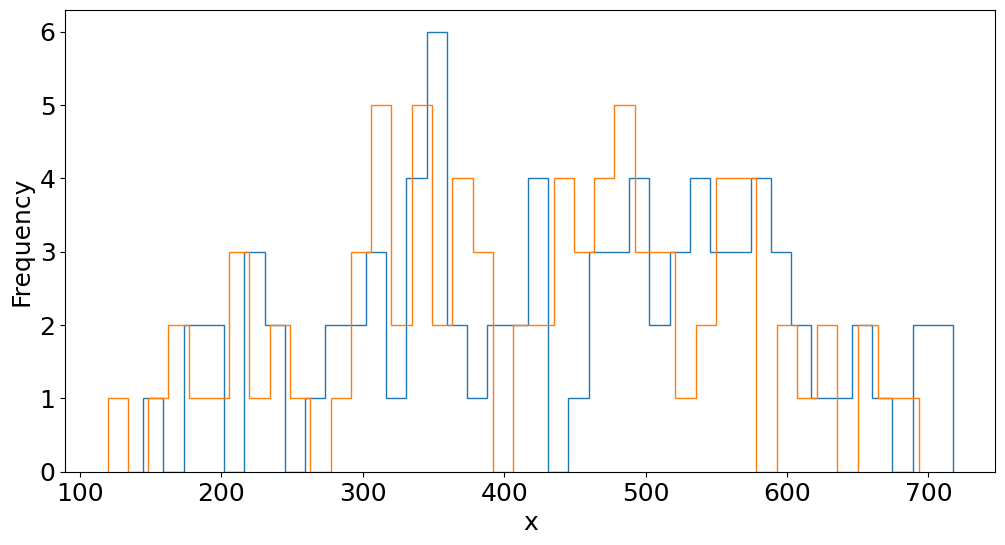

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(Dom_grip, bins=40, histtype='step', label='histogram' )
ax.set(xlabel="x", ylabel="Frequency");
ax.hist(Non_Dom_grip, bins=40, histtype='step', label='histogram' )


plt.show()


### Kolmogorov smirnoff

# Problem 4.2

In [204]:
def read_molecule(filename):
	dat = pd.read_csv(filename, sep = ',', header = 0, names = ["size", "intensity"]) 
	return dat

Molecule = read_molecule("data_MoleculeTypes.txt")
size = Molecule["size"]
intensity = Molecule["intensity"]

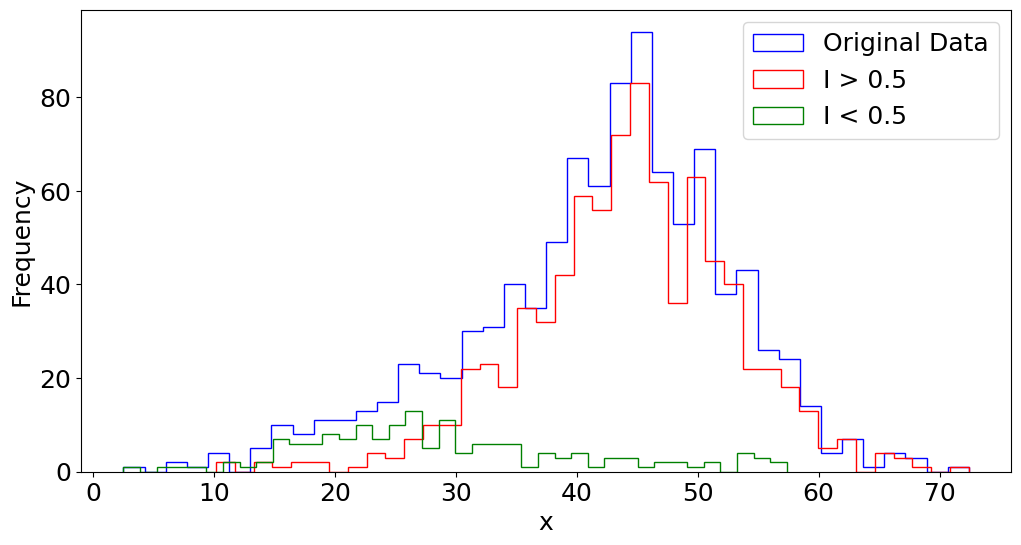

In [205]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(size, bins=40, histtype='step', label='Original Data', color = 'Blue')
ax.hist(size[np.flatnonzero(intensity>0.5)], bins=40, histtype='step', label='I > 0.5', color = 'Red')
ax.hist(size[np.flatnonzero(intensity<0.5)], bins=40, histtype='step', label='I < 0.5', color = 'Green')
ax.set(xlabel="x", ylabel="Frequency");
ax.legend()

In [97]:
def gauss_fit(x,sigma, mu, N):
    return  N*(np.exp(-(x-mu)**2/(2*sigma**2)))/ (sigma*np.sqrt(2*np.pi))

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(size, bins=40)
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)
x = x[y>0]
y = y[y>0]
sy = sy[sy>0]

m = LeastSquares(x, y, sy, gauss_fit)
# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

m = Minuit(m,sigma=20, mu=45, N=100)
m.errordef = 1.0     # This is the definition for ChiSqaure fits
m.migrad()
m.hesse()
print(*m.values)

9.310291854297557 42.62095358783883 1542.1065534302668


In [98]:
def chi2_owncalc(x,mu, sigma, N):
	y_fit = gauss_fit(x,mu, sigma, N)
	chi2 = np.sum(((y - y_fit) / sy)**2)
	return chi2

print(chi2_owncalc(x,*m.values), stats.chi2.sf(chi2_owncalc(x,*m.values), 33))

105.86952288030615 1.4439414865771582e-09


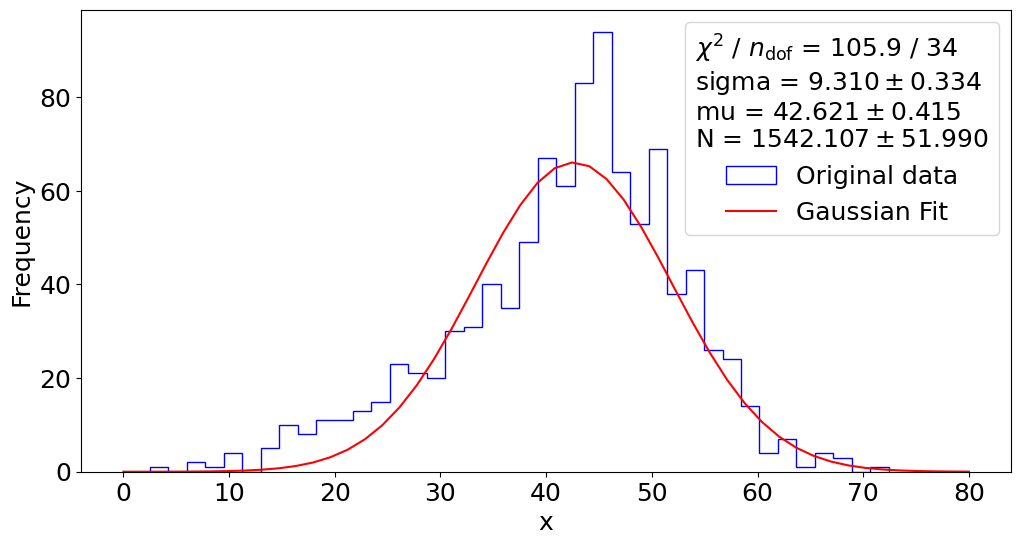

In [99]:
fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(x) - m.nfit}",]
for p, v, e in zip(m.parameters, m.values, m.errors):
	fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")


fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(size, bins=40, histtype='step', label='Original data', color = 'Blue')
ax.plot(np.linspace(0,80), gauss_fit(np.linspace(0,80),*m.values),label = 'Gaussian Fit', color = 'Red')
ax.set(xlabel="x", ylabel="Frequency");
ax.legend(title="\n".join(fit_info));


In [100]:
kstest(x, gauss_fit(x,*m.values))

KstestResult(statistic=0.40540540540540543, pvalue=0.004179157677663992)

In [104]:
def gauss_fit(x,sigma, mu, N):
    return  N*(np.exp(-(x-mu)**2/(2*sigma**2)))/ (sigma*np.sqrt(2*np.pi))

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(size[np.flatnonzero(intensity>0.5)], bins=40)
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)
x = x[y>0]
y = y[y>0]
sy = sy[sy>0]

m = LeastSquares(x, y, sy, gauss_fit)
# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

m = Minuit(m,sigma=20, mu=45, N=100)
m.errordef = 1.0     # This is the definition for ChiSqaure fits
m.migrad()
m.hesse()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 48.87 (chi2/ndof = 1.5)    │              Nfcn = 107              │
│ EDM = 6.61e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ sigma │   8.21    │   0.26    │            │            │         │         │       │
│ 1 │ mu    │   44.59   │   0.30    │            │            │         │         │       │
│ 2 │ N     │  1.22e3   │  0.04e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │    sigma       mu        N │
├───────┼────────────────────────────┤
│ sigma │   0.0691 -0.00275    0.402 │
│    mu │ -0.00275   0.0901    0.138 │
│     N │    0.402    0.138 1.92e+03 │
└───────┴────────────────────────────┘

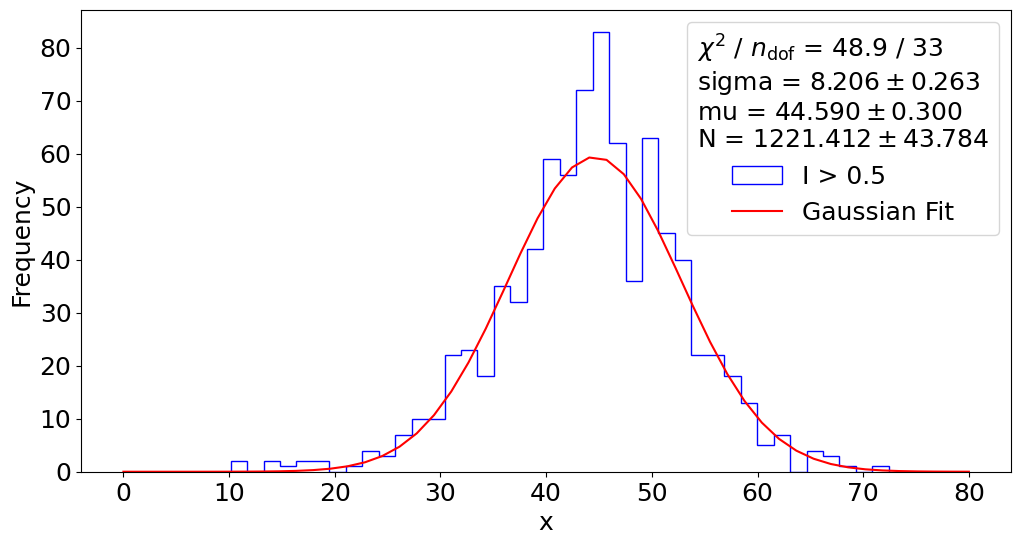

In [105]:
fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(x) - m.nfit}",]
for p, v, e in zip(m.parameters, m.values, m.errors):
	fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")


fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(size[np.flatnonzero(intensity>0.5)], bins=40, histtype='step', label='I > 0.5', color = 'Blue')
ax.plot(np.linspace(0,80), gauss_fit(np.linspace(0,80), *m.values), label = 'Gaussian Fit', color = 'Red')
ax.set(xlabel="x", ylabel="Frequency");
ax.legend(title="\n".join(fit_info));

In [106]:
def chi2_owncalc(x,mu, sigma, N):
	y_fit = gauss_fit(x,mu, sigma, N)
	chi2 = np.sum(((y - y_fit) / sy)**2)
	return chi2

print(chi2_owncalc(x,*m.values), stats.chi2.sf(chi2_owncalc(x,*m.values), 33))

48.87097737633424 0.037052535596955316


In [103]:
kstest(x, gauss_fit(x, *m.values))

KstestResult(statistic=0.4722222222222222, pvalue=0.0005322080152247216)

In [107]:
def gauss_fit(x,sigma, mu, N):
    return  N*(np.exp(-(x-mu)**2/(2*sigma**2)))/ (sigma*np.sqrt(2*np.pi))

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(size[np.flatnonzero(intensity<0.5)], bins=40)
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)
x = x[y>0]
y = y[y>0]
sy = sy[sy>0]

m = LeastSquares(x, y, sy, gauss_fit)
# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

m = Minuit(m,sigma=20, mu=45, N=100)
m.errordef = 1.0     # This is the definition for ChiSqaure fits
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 40.78 (chi2/ndof = 1.2)    │              Nfcn = 127              │
│ EDM = 1.06e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ sigma │    8.6    │    1.2    │            │            │         │         │       │
│ 1 │ mu    │   25.4    │    0.9    │            │            │         │         │       │
│ 2 │ N     │    163    │    15     │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │ sigma    mu     N │
├───────┼───────────────────┤
│ sigma │  1.55 0.509  2.01 │
│    mu │ 0.509 0.862 0.114 │
│     N │  2.01 0.114   231 │
└───────┴───────────────────┘

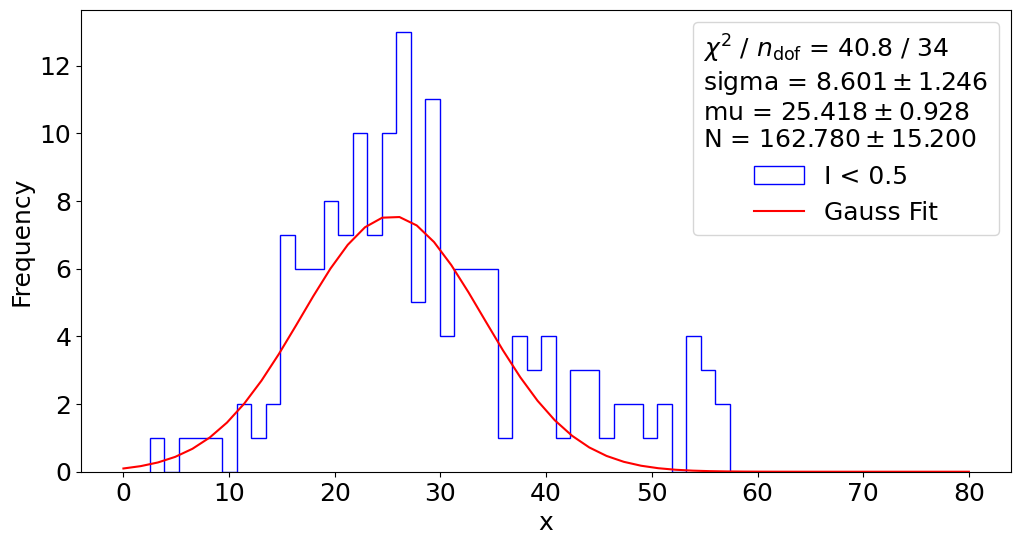

In [108]:
fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(x) - m.nfit}",]
for p, v, e in zip(m.parameters, m.values, m.errors):
	fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")


fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(size[np.flatnonzero(intensity<0.5)], bins=40, histtype='step', label='I < 0.5', color = 'Blue')
ax.plot(np.linspace(0,80), gauss_fit(np.linspace(0,80), *m.values), label = 'Gauss Fit', color = 'Red')
ax.set(xlabel="x", ylabel="Frequency");
ax.legend(title="\n".join(fit_info));

In [109]:
def chi2_owncalc(x,mu, sigma, N):
	y_fit = gauss_fit(x,mu, sigma, N)
	chi2 = np.sum(((y - y_fit) / sy)**2)
	return chi2

print(chi2_owncalc(x,*m.values), stats.chi2.sf(chi2_owncalc(x,*m.values), 34))

40.77739470998244 0.19695371622241342


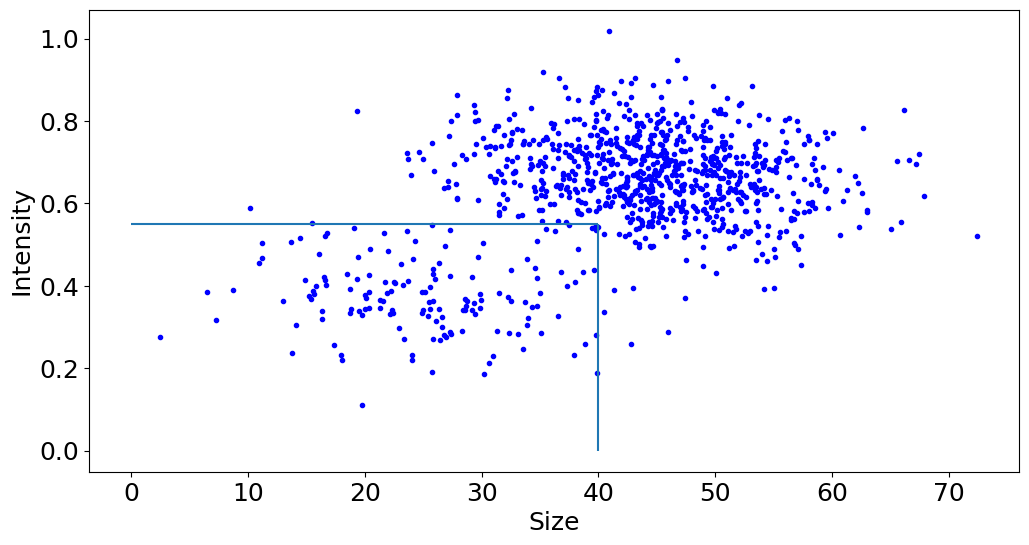

In [117]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(size,intensity, '.', color = 'Blue')
ax.hlines(0.55,0,40)
ax.vlines(40,0,0.55)
ax.set(xlabel="Size", ylabel="Intensity");

In [119]:
#Calculating how many molecules are in the new distriubution

low_size = np.flatnonzero(size < 40)
low_intens = np.flatnonzero(intensity < 0.55)
small_molecule = np.intersect1d(low_size,low_intens)

print(len(small_molecule))

152


# Problem 5.1

In [254]:
def read_algae(filename):
	dat = pd.read_csv(filename, sep = ',', header = 0, names = ["time", "area", "area_err"]) 
	return dat

algae = read_algae("data_AlgaeGrowth.txt")
time = algae["time"]
area = algae["area"]
area_err = algae["area_err"]

Text(0, 0.5, 'Area')

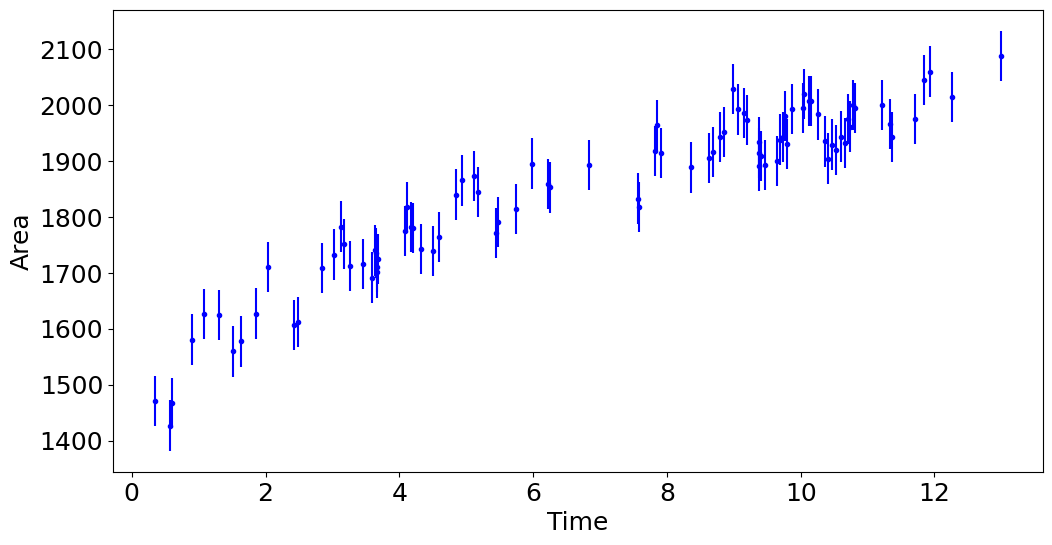

In [255]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(time, area, area_err, fmt = '.', color = 'Blue')
ax.set_xlabel('Time')
ax.set_ylabel('Area')


In [256]:
def third_fit(x,a,b,c,d,N):
    return  N*(a*x**3+b*x**2+c*x+d)

m = LeastSquares(time, area, area_err, third_fit)
# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

m = Minuit(m, a = 0, b = 1, c = 10, d=10, N = 30)
m.errordef = 1.0     # This is the definition for ChiSqaure fits
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 71.64 (chi2/ndof = 0.8)    │              Nfcn = 464              │
│ EDM = 0.000119 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.037   │   0.020   │            │            │         │         │       │
│ 1 │ b    │   -1.0    │    0.5    │            │            │         │         │       │
│ 2 │ c    │    11     │     5     │            │            │         │         │       │
│ 3 │ d    │    130    │    60     │            │            │         │         │       │
│ 4 │ N    │    11     │     5     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────────────────────────────────────────┐
│   │        a        b        c        d        N │
├───┼──────────────────────────────────────────────┤
│ a │  0.00041 -0.00985   0.0941    0.951  -0.0857 │
│ b │ -0.00985    0.243     -2.4      -25     2.25 │
│ c │   0.0941     -2.4       25      278    -24.8 │
│ d │    0.951      -25      278 3.37e+03     -298 │
│ N │  -0.0857     2.25    -24.8     -298     26.4 │
└───┴──────────────────────────────────────────────┘

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


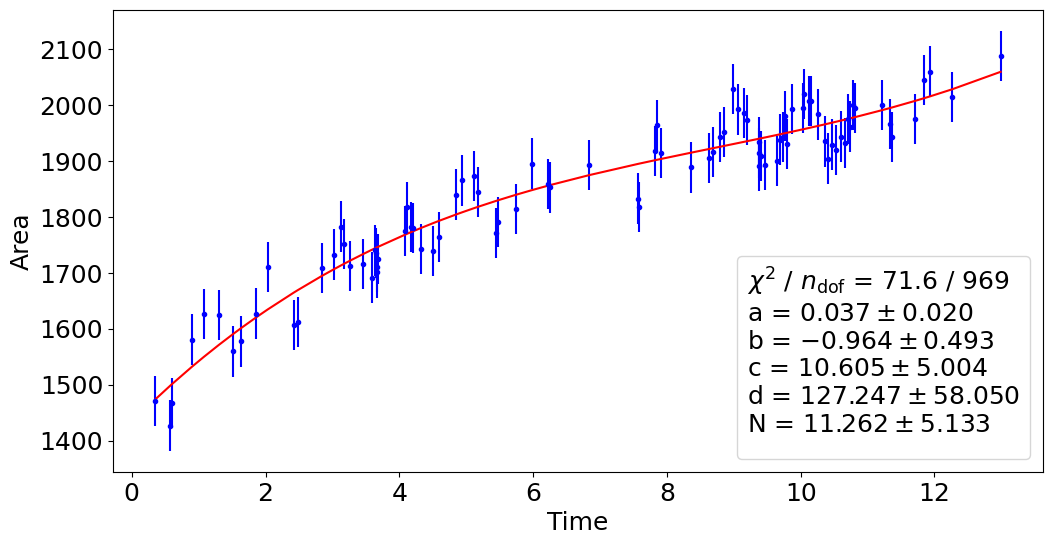

In [257]:
fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(x) - m.nfit}",]
for p, v, e in zip(m.parameters, m.values, m.errors):
	fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

	
fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(time, area, area_err, fmt = '.', color = 'Blue')
ax.plot(time, third_fit(time, *m.values), color = 'Red')
ax.set_xlabel('Time')
ax.set_ylabel('Area')
ax.legend(title="\n".join(fit_info));

In [258]:
def chi2_owncalc(x,a,b,c,d,N):
	y_fit = third_fit(x,a,b,c,d,N)
	chi2 = np.sum(((y - y_fit) / sy)**2)
	return chi2

print(chi2_owncalc(x,*m.values), stats.chi2.sf(chi2_owncalc(x,*m.values), 32))

1.4645350049767453e+21 0.0


No this is a very bad fit

Text(0, 0.5, 'Area')

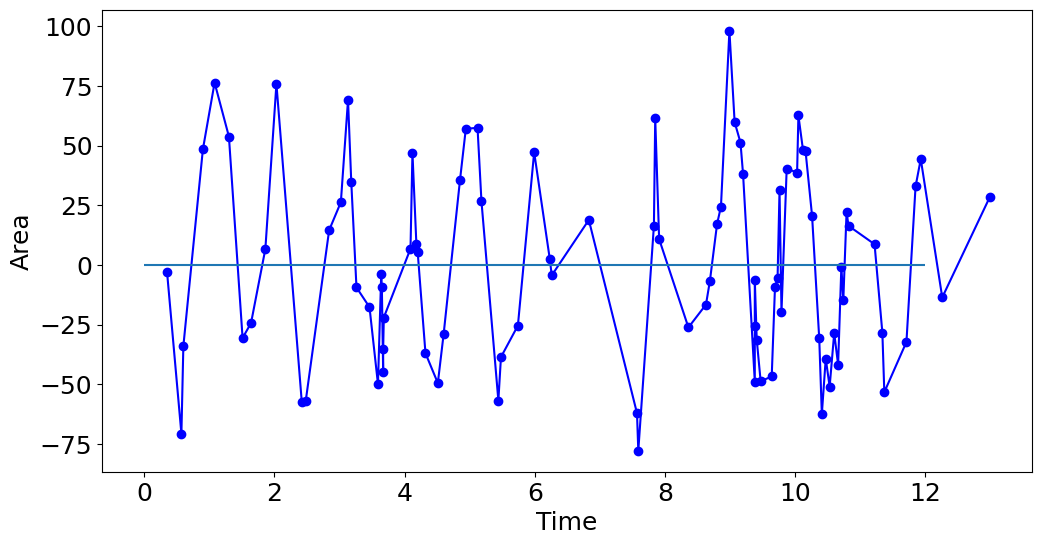

In [263]:
res = area - third_fit(time, *m.values)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time, res, 'o-', color = 'Blue')
ax.hlines(0,0,12)
ax.set_xlabel('Time')
ax.set_ylabel('Area')

# below is the runs test

In [262]:
def ww_runs(pos,neg,tot):

	mu = 2*pos*neg/tot + 1

	var = 2*pos*neg*(2*pos*neg-tot)/(tot**2*(tot-1))

	return mu, np.sqrt(var)


Npos = []
Nneg = []

for i in res:
	if i > 0:
		Npos.append(i)
	else:
		Nneg.append(i)

Npos = np.array(Npos)
Nneg = np.array(Nneg)
Ntot = len(Npos) + len(Nneg)

print(len(Npos), len(Nneg))

print(ww_runs(len(Npos),len(Nneg),Ntot))

42 48
(45.8, 4.695491502434884)


In [266]:
(45-28)/np.sqrt(45)

2.5342103744997617

In [267]:
def third_fit_mod(x,a,b,c,d,e,f,N,K):
    return  N*(a*x**3+b*x**2+c*x+d) + K*np.cos(e*x+f)

m = LeastSquares(time, area, area_err, third_fit_mod)
# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

m = Minuit(m, a = 0.75, b = -1, c = 116, d=1400, e=5.6 ,f = -40, N = 20, K = -20)
m.errordef = 1.0     # This is the definition for ChiSqaure fits
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 13.57 (chi2/ndof = 0.2)    │             Nfcn = 1378              │
│ EDM = 2.43e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   -0.7    │    0.5    │            │            │         │         │       │
│ 1 │ b    │    20     │    14     │            │            │         │         │       │
│ 2 │ c    │  -0.25e3  │  0.17e3   │            │            │         │         │       │
│ 3 │ d    │  -3.6e3   │   2.3e3   │            │            │         │         │       │
│ 4 │ e    │   6.30    │   0.04    │            │            │         │         │       │
│ 5 │ f    │  -59.93   │   0.30    │            │            │         │         │       │
│ 6 │ N    │   -0.41   │   0.26    │            │            │         │         │       │
│ 7 │ K    │    -53    │     7     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────────────────────────────────────────────┐
│   │         a         b         c         d         e         f         N         K │
├───┼─────────────────────────────────────────────────────────────────────────────────┤
│ a │     0.282      -7.3      79.1       958 -0.000498   0.00166    -0.111    -0.333 │
│ b │      -7.3       198 -2.26e+03 -2.86e+04      0.01   -0.0383       3.3       6.6 │
│ c │      79.1 -2.26e+03  2.76e+04   3.7e+05   -0.0568     0.282     -42.4     -38.1 │
│ d │       958 -2.86e+04   3.7e+05  5.28e+06    0.0941    -0.726      -602      63.3 │
│ e │ -0.000498      0.01   -0.0568    0.0941   0.00135   -0.0101  1.31e-06     0.031 │
│ f │   0.00166   -0.0383     0.282    -0.726   -0.0101    0.0911 -2.51e-06    -0.249 │
│ N │    -0.111       3.3     -42.4      -602  1.31e-06 -2.51e-06    0.0687   0.00021 │
│ K │    -0.333       6.6     -38.1      63.3     0.031    -0.249   0.00021      49.1 │
└───┴─────────────────────────────────────────────────────────────────────────────────┘

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


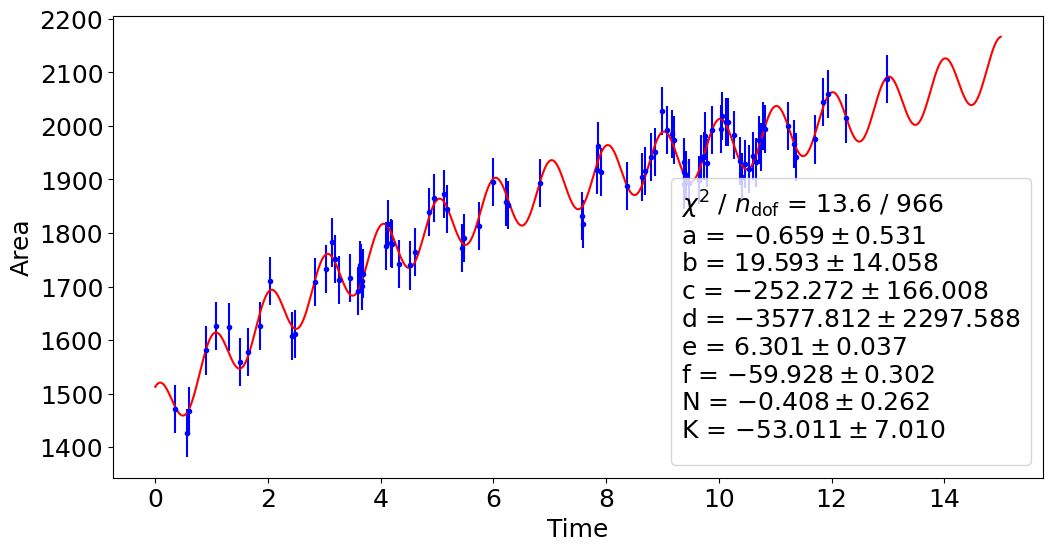

In [268]:
fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(x) - m.nfit}",]
for p, v, e in zip(m.parameters, m.values, m.errors):
	fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

time_x = np.linspace(0,15, 1000)
	
fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(time, area, area_err, fmt = '.', color = 'Blue')
ax.plot(time_x, third_fit_mod(time_x, *m.values), color = 'Red')
ax.set_xlabel('Time')
ax.set_ylabel('Area')
ax.legend(title="\n".join(fit_info));

In [274]:

res_mod = area - third_fit_mod(time, *m.values)

Npos = []
Nneg = []

for i in res_mod:
	if i > 0:
		Npos.append(i)
	else:
		Nneg.append(i)

Npos = np.array(Npos)
Nneg = np.array(Nneg)
Ntot = len(Npos) + len(Nneg)

print(len(Npos),len(Nneg))
print(ww_runs(len(Npos),len(Nneg),Ntot))

43 47
(45.91111111111111, 4.707270005030894)


In [272]:
(45-42)/np.sqrt(45)

0.4472135954999579

Text(0, 0.5, 'Area')

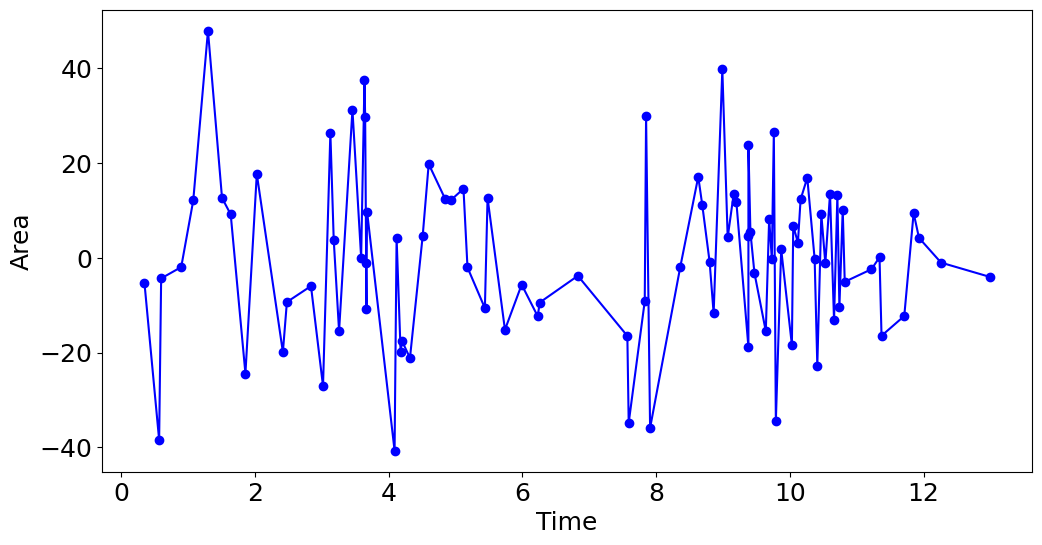

In [275]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time, res_mod, 'o-', color = 'Blue')
ax.set_xlabel('Time')
ax.set_ylabel('Area')

# Problem 5.2

In [219]:
def read_bohr(filename):
	dat = pd.read_csv(filename, sep = ',', header = 0, names = ["wavelength", "voltage"]) 
	return dat

bohr = read_bohr("data_BohrHypothesis.txt")
wavelength = bohr["wavelength"]
voltage = bohr["voltage"]

Text(0, 0.5, 'Frequency')

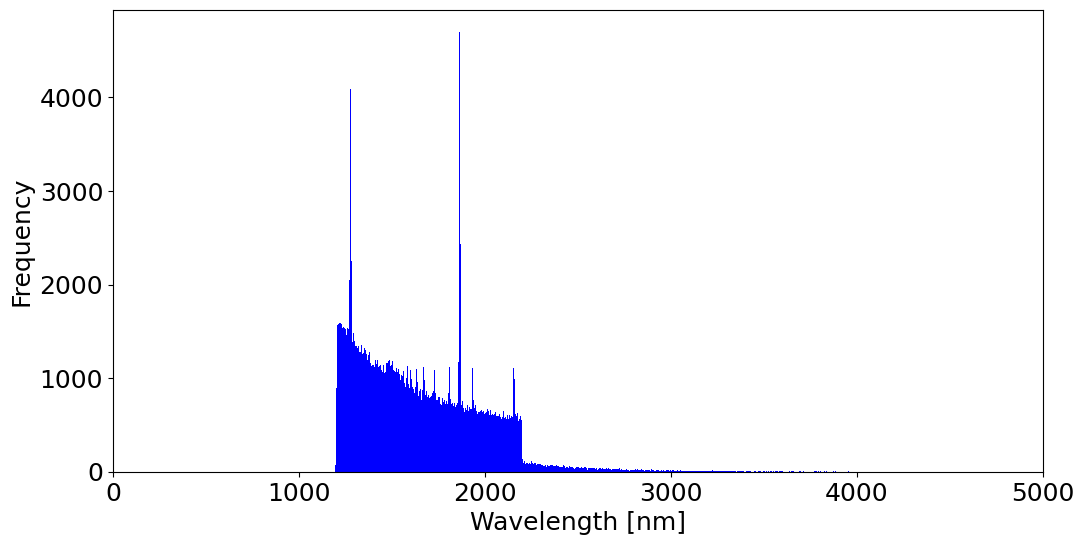

In [220]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(wavelength, bins = 1000, color = 'Blue')
ax.set_xlim(0,5000)
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Frequency')


Text(0, 0.5, 'Frequency')

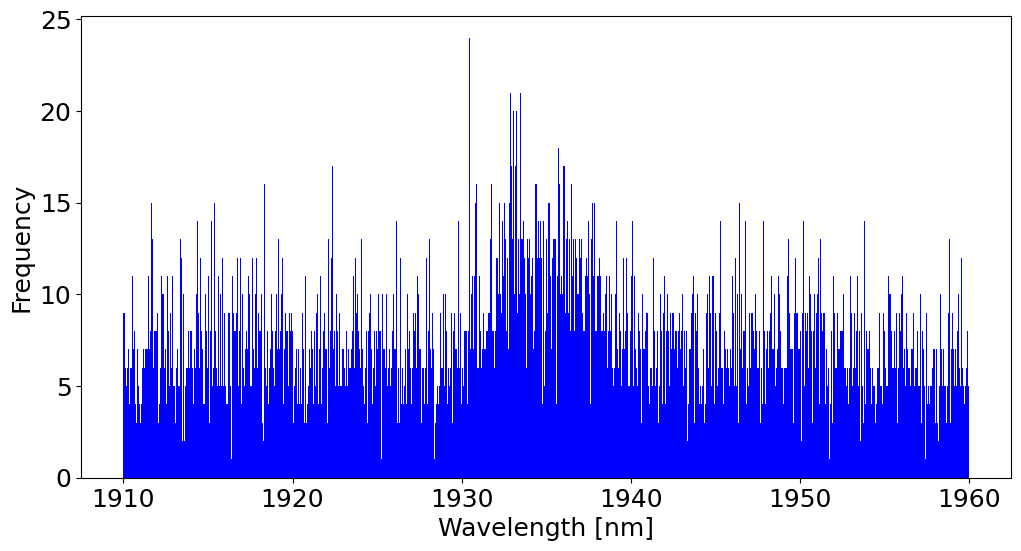

In [238]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(wavelength, bins = 1000, range=(1910, 1960), color = 'Blue')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Frequency')


Text(0, 0.5, 'Frequency')

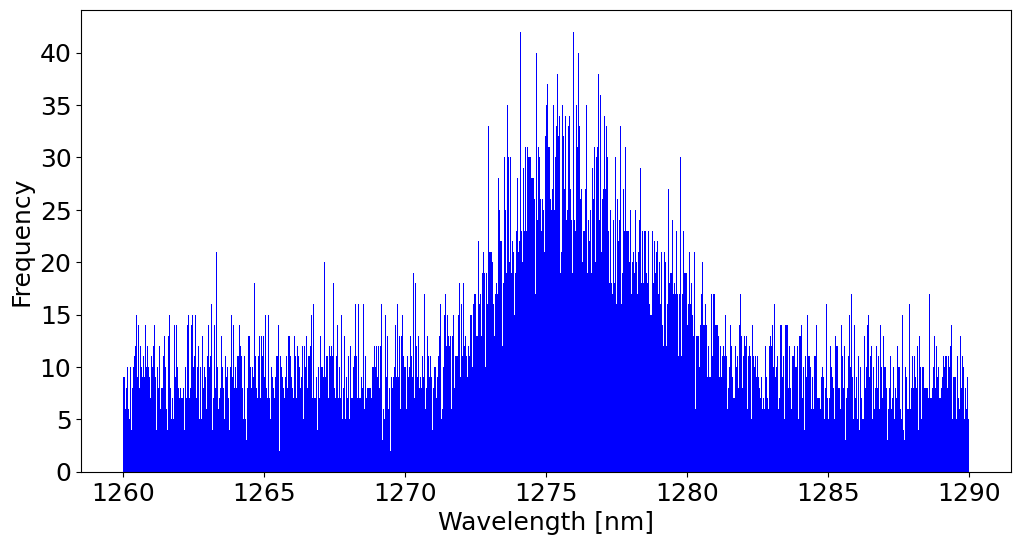

In [221]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(wavelength, bins = 1000, range=(1260, 1290), color = 'Blue')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Frequency')


Text(0, 0.5, 'Frequency')

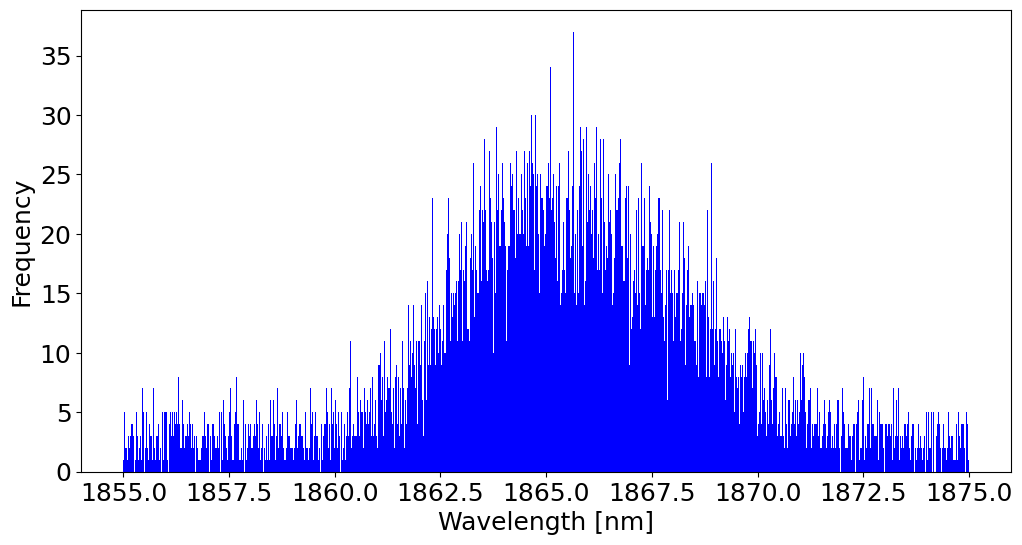

In [222]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(wavelength, bins = 1000, range=(1855, 1875), color = 'Blue')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Frequency')

2.4362441776990726 1865.6727292718551 122.82324272233069 2.0807134696734284


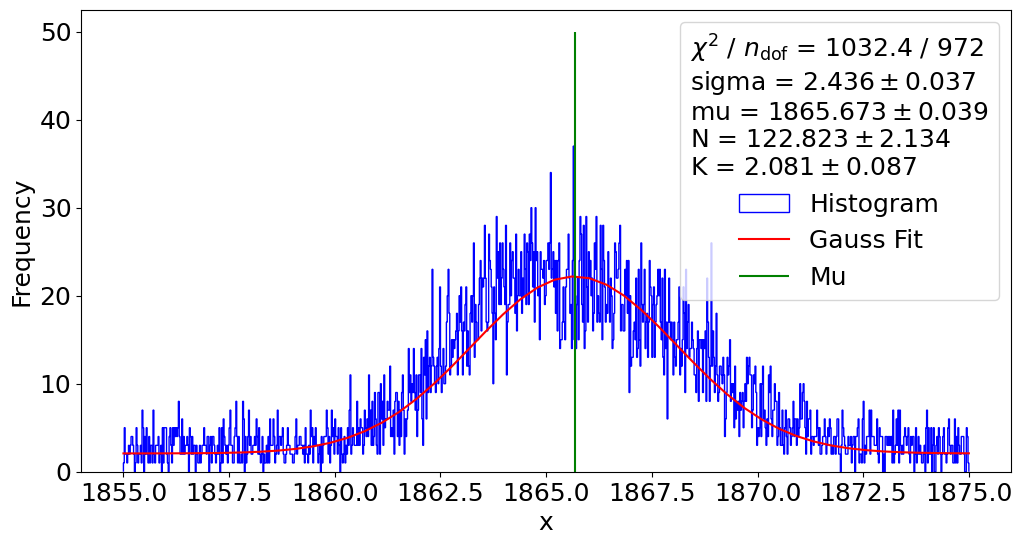

In [223]:
def gauss_fit(x,sigma, mu, N,K):
    return  N*(np.exp(-(x-mu)**2/(2*sigma**2)))/ (sigma*np.sqrt(2*np.pi)) +K

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(wavelength, bins=1000, range=(1855, 1875))
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)
x = x[y>0]
y = y[y>0]
sy = sy[sy>0]

m = LeastSquares(x, y, sy, gauss_fit)

m = Minuit(m,sigma=10, mu=1876, N=300, K=1)
m.errordef = 1.0     # This is the definition for ChiSqaure fits
m.migrad()
m.hesse()

print(*m.values)

fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(x) - m.nfit}",]
for p, v, e in zip(m.parameters, m.values, m.errors):
	fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")


fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(wavelength, bins=1000, histtype='step', label='Histogram', range =(1855, 1875), color ='Blue')
ax.plot(np.linspace(1855, 1875), gauss_fit(np.linspace(1855, 1875), *m.values), label = 'Gauss Fit', color = 'Red')
ax.vlines(m.values[1], 0, 50, color = 'green', label = 'Mu')
ax.set(xlabel="x", ylabel="Frequency");
ax.legend(title="\n".join(fit_info));


In [224]:
2.44/np.sqrt(len(counts))

0.07715957490810846

In [225]:
def chi2_owncalc(x,sigma, mu, N,K):
	y_fit = gauss_fit(x,sigma, mu, N,K)
	chi2 = np.sum(((y - y_fit) / sy)**2)
	return chi2

print(chi2_owncalc(x,*m.values), stats.chi2.sf(chi2_owncalc(x,*m.values), 972))

#Calculate degrees of freedom
print(len(y[y>0])-1)

1032.4119914141445 0.0872609918683947
975


2.5258853840216218 1276.1775909257328 82.21590233670587 4.99800813332835


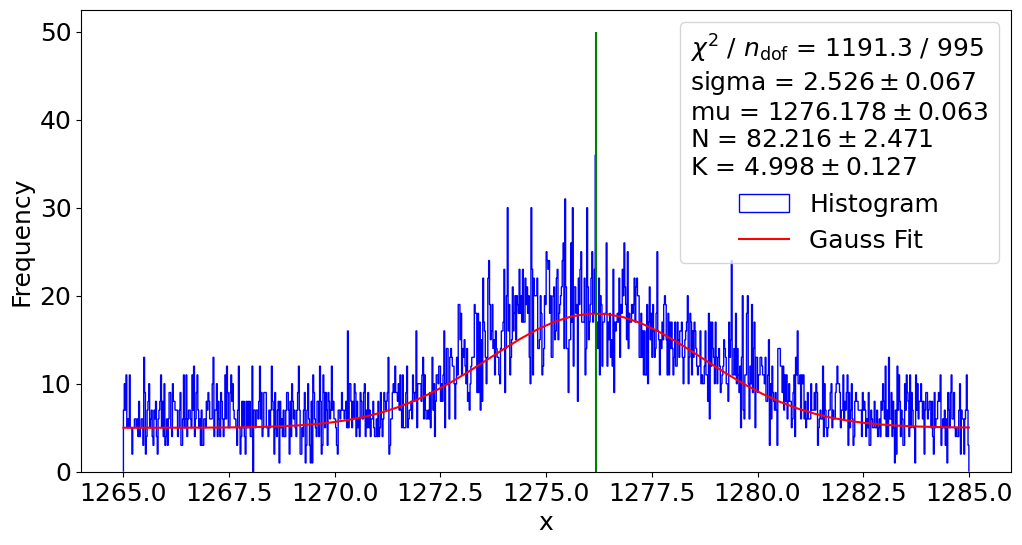

In [226]:
def gauss_fit(x,sigma, mu, N, K):
    return  N*(np.exp(-(x-mu)**2/(2*sigma**2)))/ (sigma*np.sqrt(2*np.pi)) +K

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(wavelength, bins=1000, range=(1265, 1285))
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)
x = x[y>0]
y = y[y>0]
sy = sy[sy>0]

m = LeastSquares(x, y, sy, gauss_fit)

m = Minuit(m,sigma=2, mu=1276, N=82, K=10)
m.errordef = 1.0     # This is the definition for ChiSqaure fits
m.migrad()
m.hesse()

print(*m.values)

fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(x) - m.nfit}",]
for p, v, e in zip(m.parameters, m.values, m.errors):
	fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")


fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(wavelength, bins=1000, histtype='step', label='Histogram', range =(1265, 1285), color = 'Blue')
ax.plot(np.linspace(1265, 1285), gauss_fit(np.linspace(1265, 1285), *m.values), label = 'Gauss Fit', color = 'Red')
ax.vlines(m.values[1], 0, 50, color = 'green')
ax.set(xlabel="x", ylabel="Frequency");
ax.legend(title="\n".join(fit_info));


In [227]:
def chi2_owncalc(x,sigma, mu, N,K):
	y_fit = gauss_fit(x,sigma, mu, N,K)
	chi2 = np.sum(((y - y_fit) / sy)**2)
	return chi2

print(chi2_owncalc(x,*m.values), stats.chi2.sf(chi2_owncalc(x,*m.values), 995))

#Calculate degrees of freedom
print(len(y[y>0])-1)

1191.316108937202 1.6236220487719498e-05
998


### Calibration

/usr/local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


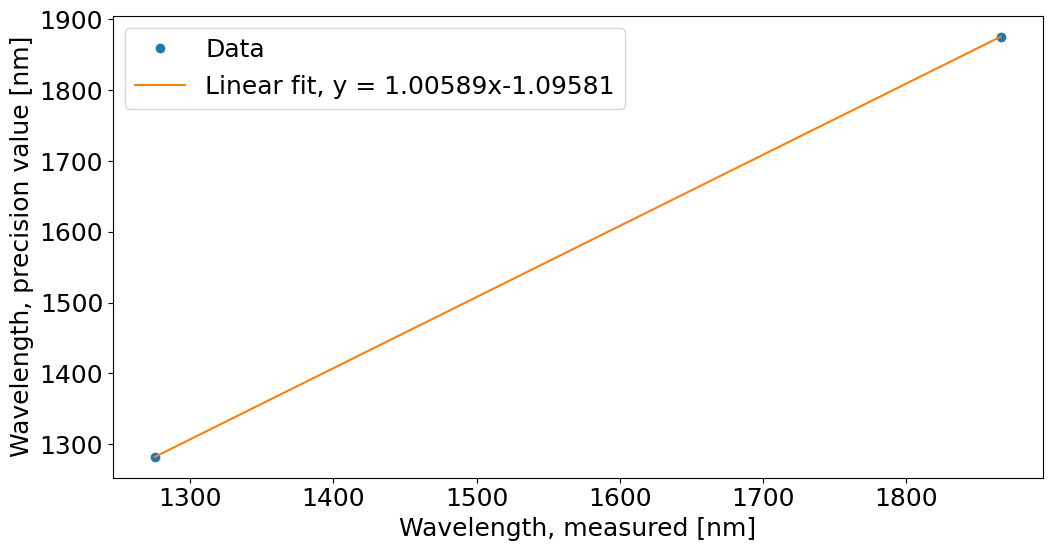

In [228]:
wavelength_fit = np.array([1275.76, 1865.75])
wavelength_precision = np.array([1282.174, 1875.637])
wavelength_fit_error = np.array([0.13, 0.03])

def line_mod(x,a,b):
    return  a*x+b

par, cov = optimize.curve_fit(line_mod,wavelength_fit, wavelength_precision)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(wavelength_fit, wavelength_precision, 'o', label = 'Data')
ax.plot(wavelength_fit, line_mod(wavelength_fit, *par), label = 'Linear fit, y = 1.00589x-1.09581')
ax.set_xlabel('Wavelength, measured [nm]')
ax.set_ylabel('Wavelength, precision value [nm]')
ax.legend()

In [244]:
def calibration(x):
	return 1.00589*x-1.09581

2.084444740834688 2153.902489803228 25.70602810426492 2.8203919581977144


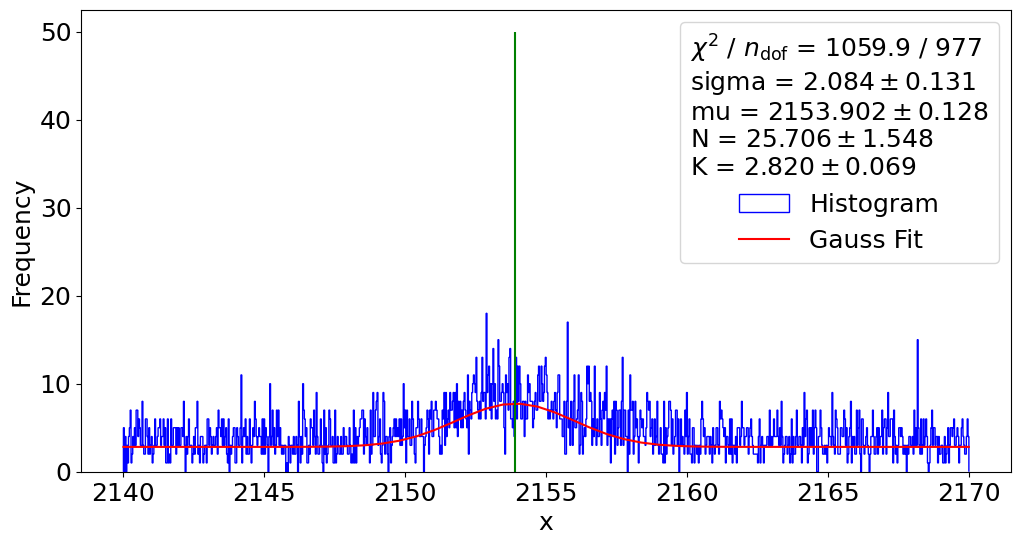

In [247]:

def gauss_fit(x,sigma, mu, N, K):
    return  N*(np.exp(-(x-mu)**2/(2*sigma**2)))/ (sigma*np.sqrt(2*np.pi)) +K

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(wavelength, bins=1000, range=(2140, 2170))
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)
x = x[y>0]
y = y[y>0]
sy = sy[sy>0]

m = LeastSquares(x, y, sy, gauss_fit)

m = Minuit(m,sigma=2, mu=2155, N=82, K=10)
m.errordef = 1.0     # This is the definition for ChiSqaure fits
m.migrad()
m.hesse()

print(*m.values)

fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(x) - m.nfit}",]
for p, v, e in zip(m.parameters, m.values, m.errors):
	fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")


fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(wavelength, bins=1000, histtype='step', label='Histogram', range =(2140, 2170), color = 'Blue')
ax.plot(np.linspace(2140, 2170), gauss_fit(np.linspace(2140, 2170), *m.values), label = 'Gauss Fit', color = 'Red')
ax.vlines(m.values[1], 0, 50, color = 'green')
ax.set(xlabel="x", ylabel="Frequency");
ax.legend(title="\n".join(fit_info));


In [248]:
2.084/np.sqrt(len(y))

0.06653699928002932

2.7621381041789896 1934.8995892114199 38.16683915311434 5.933706235465061


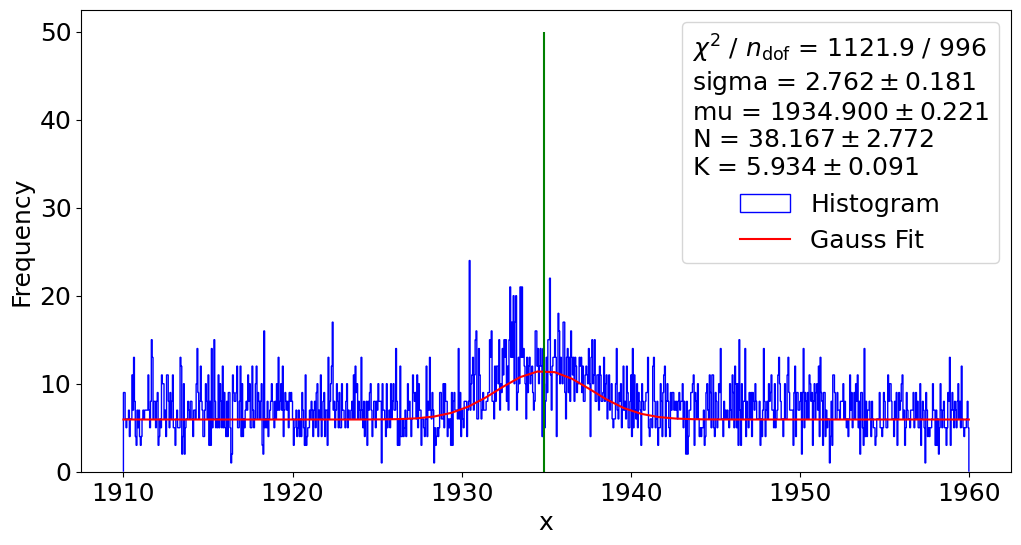

In [249]:

def gauss_fit(x,sigma, mu, N, K):
    return  N*(np.exp(-(x-mu)**2/(2*sigma**2)))/ (sigma*np.sqrt(2*np.pi)) +K

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(wavelength, bins=1000, range=(1910, 1960))
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)
x = x[y>0]
y = y[y>0]
sy = sy[sy>0]

m = LeastSquares(x, y, sy, gauss_fit)

m = Minuit(m,sigma=2, mu=1935, N=82, K=10)
m.errordef = 1.0     # This is the definition for ChiSqaure fits
m.migrad()
m.hesse()

print(*m.values)

fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(x) - m.nfit}",]
for p, v, e in zip(m.parameters, m.values, m.errors):
	fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")


fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(wavelength, bins=1000, histtype='step', label='Histogram', range =(1910, 1960), color = 'Blue')
ax.plot(np.linspace(1910, 1960), gauss_fit(np.linspace(1910, 1960), *m.values), label = 'Gauss Fit', color = 'Red')
ax.vlines(m.values[1], 0, 50, color = 'green')
ax.set(xlabel="x", ylabel="Frequency");
ax.legend(title="\n".join(fit_info));


In [251]:
2.762/np.sqrt(len(y))

0.08734210897385064

1.2938238690439414 1727.6063433720938 4.220609020008782 2.726157146959173


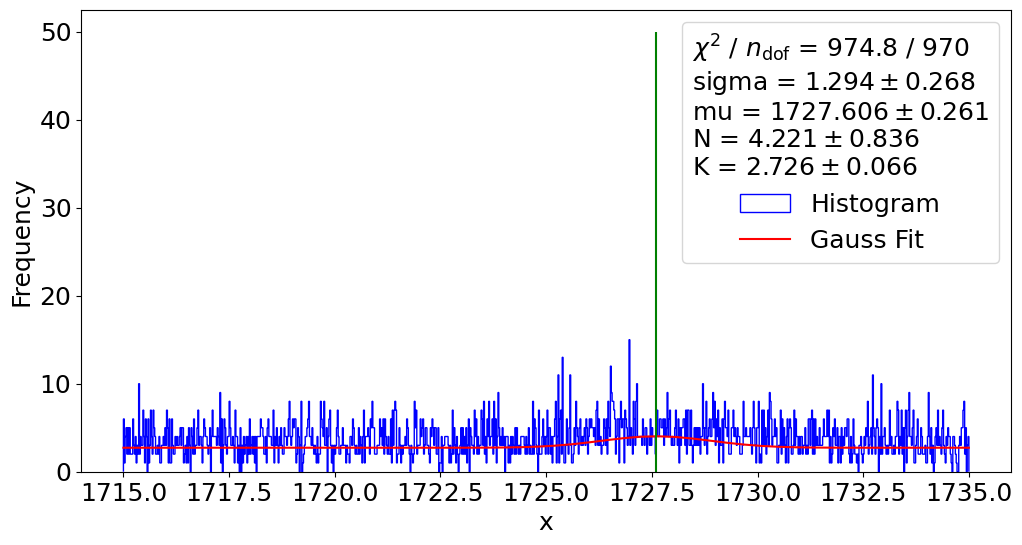

In [252]:

def gauss_fit(x,sigma, mu, N, K):
    return  N*(np.exp(-(x-mu)**2/(2*sigma**2)))/ (sigma*np.sqrt(2*np.pi)) +K

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(wavelength, bins=1000, range=(1715, 1735))
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)
x = x[y>0]
y = y[y>0]
sy = sy[sy>0]

m = LeastSquares(x, y, sy, gauss_fit)

m = Minuit(m,sigma=2, mu=1730, N=82, K=10)
m.errordef = 1.0     # This is the definition for ChiSqaure fits
m.migrad()
m.hesse()

print(*m.values)

fit_info = [f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(x) - m.nfit}",]
for p, v, e in zip(m.parameters, m.values, m.errors):
	fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")


fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(wavelength, bins=1000, histtype='step', label='Histogram', range =(1715, 1735), color = 'Blue')
ax.plot(np.linspace(1715, 1735), gauss_fit(np.linspace(1715, 1735), *m.values), label = 'Gauss Fit', color = 'Red')
ax.vlines(m.values[1], 0, 50, color = 'green')
ax.set(xlabel="x", ylabel="Frequency");
ax.legend(title="\n".join(fit_info));


In [253]:
1.294/np.sqrt(len(y))

0.0414624344464465